## CNN Image classifier for the SVHN dataset


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

[SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

This uses the pre-cropped datasets in Format 2.

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

# Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip SVHN data
zip_path = "/content/drive/My Drive/Seattle University/CPSC5610 - Artificial Intelligence/Data/svnh_data.zip"
extract_root = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

In [ ]:
# Load .mat files
data_directory = os.path.join(extract_root, "svnh_data")
train = scipy.io.loadmat(os.path.join(data_directory, "train_32x32.mat"))
test = scipy.io.loadmat(os.path.join(data_directory, "test_32x32.mat"))
extra = scipy.io.loadmat(os.path.join(data_directory, "extra_32x32.mat"))

In [ ]:
# Subset extra dataset
#subset_size = 200000
#indices = np.random.choice(extra['X'].shape[-1], subset_size, replace=False)
#extra_X_subset = extra['X'][:, :, :, indices]
#extra_y_subset = extra['y'][indices]

In [ ]:
# Transpose images from (32, 32, 3, N) to (N, 32, 32, 3)
train_images = train['X'].transpose(3, 0, 1, 2) # from (32, 32, 3, 73257) to (73257, 32, 32, 3)
test_images = test['X'].transpose(3, 0, 1, 2) # from (32, 32, 3, 26032) to (26032, 32, 32, 3)
extra_images = extra['X'].transpose(3, 0, 1, 2) # from (32, 32, 3, 531131) to (531131, 32, 32, 3)

In [ ]:
# Flatten labels
train_labels = train['y'].flatten() # (73257,)
test_labels = test['y'].flatten() # (26032,)
extra_labels = extra['y'].flatten() # (531131,)

In [ ]:
train_images.shape # samples, height, width, channels

(73257, 32, 32, 3)

In [ ]:
train_labels.shape # samples

(73257,)

In [ ]:
test_images.shape # samples, height, width, channels

(26032, 32, 32, 3)

In [ ]:
test_labels.shape # samples

(26032,)

In [ ]:
extra_images.shape # samples, height, width, channels

(531131, 32, 32, 3)

In [ ]:
extra_labels.shape # samples

(531131,)

Examine a single image

In [ ]:
single_image = train_images[25]
single_label = train_labels[25]

Label: 3


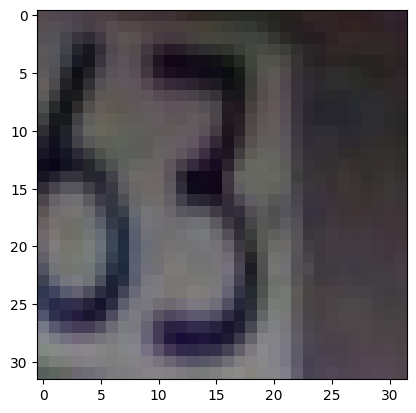

In [ ]:
plt.imshow(single_image)
print(f"Label: {single_label}")

Label: 3


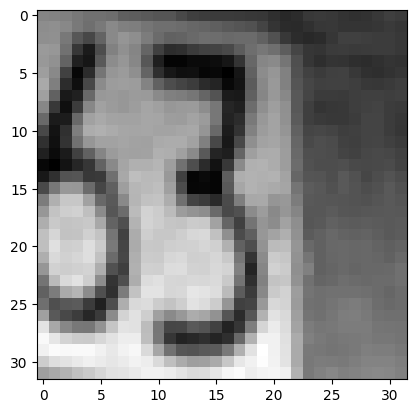

In [ ]:
single_image_gray = np.mean(single_image, axis=-1)
plt.imshow(single_image_gray, cmap="gray")
print(f"Label: {single_label}")

In [ ]:
np.unique(train_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [ ]:
np.unique(test_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [ ]:
np.unique(extra_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [ ]:
# Replaces '10' labels with '0' labels
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

In [ ]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
np.unique(test_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
np.unique(extra_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# Normalize pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0
extra_images = extra_images / 255.0

In [ ]:
normalized_single_image = train_images[25]

In [ ]:
normalized_single_image

array([[[0.32941176, 0.28627451, 0.30588235],
        [0.31764706, 0.28235294, 0.31372549],
        [0.30980392, 0.2745098 , 0.30980392],
        ...,
        [0.19215686, 0.13333333, 0.15686275],
        [0.19607843, 0.14509804, 0.17647059],
        [0.19215686, 0.12941176, 0.17254902]],

       [[0.3372549 , 0.30980392, 0.32156863],
        [0.33333333, 0.31372549, 0.3372549 ],
        [0.31764706, 0.29803922, 0.3254902 ],
        ...,
        [0.18431373, 0.13333333, 0.14509804],
        [0.18823529, 0.1372549 , 0.16078431],
        [0.18431373, 0.12156863, 0.15686275]],

       [[0.32941176, 0.32156863, 0.32941176],
        [0.3254902 , 0.32156863, 0.34117647],
        [0.27843137, 0.27058824, 0.29803922],
        ...,
        [0.19607843, 0.15294118, 0.15294118],
        [0.19607843, 0.15294118, 0.15686275],
        [0.18823529, 0.13333333, 0.15294118]],

       ...,

       [[0.50980392, 0.53333333, 0.50980392],
        [0.52941176, 0.54509804, 0.53333333],
        [0.52941176, 0

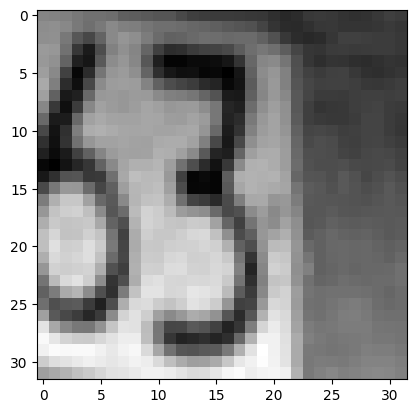

In [ ]:
normalized_single_image_gray = np.mean(normalized_single_image, axis=-1)
plt.imshow(normalized_single_image_gray, cmap="gray")

In [ ]:
# One-hot encode the labels
cat_train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
cat_test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)
cat_extra_labels = tf.keras.utils.to_categorical(extra_labels, num_classes=10)

In [ ]:
train_labels[25]

np.uint8(3)

In [ ]:
cat_train_labels[25]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Combine train and extra sets
train_images = np.concatenate((train_images, extra_images), axis=0)
cat_train_labels = np.concatenate((cat_train_labels, cat_extra_labels), axis=0)

In [ ]:
train_images.shape

(604388, 32, 32, 3)

In [ ]:
cat_train_labels.shape

(604388, 10)

# Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [ ]:
random_indices = np.random.choice(604388, size=20, replace=False)

In [ ]:
random_indices

array([497288, 570002, 556502, 183622, 212624, 467273,  47412, 417272,
       490139, 141131, 316092, 196512,   4671, 508397, 260117,  16556,
        88078, 334103, 237877, 403208])

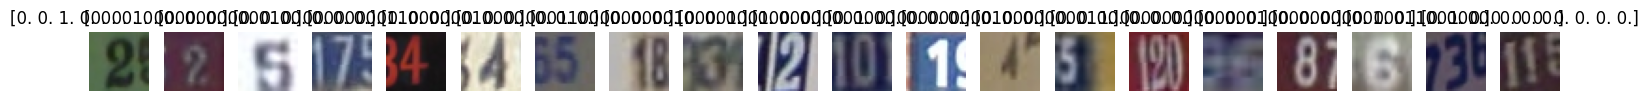

In [ ]:
plt.figure(figsize=(15, 4))

for i, idx in enumerate(random_indices):
    image = train_images[idx, :, :, :] # shape: (32, 32, 3)
    label = cat_train_labels[idx]

    plt.subplot(1, 20, i + 1)
    plt.imshow(image)
    plt.title(f"{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. Hint: retain the channel dimension, which will now have size 1.

In [ ]:
train_images_gray = np.mean(train_images, axis=-1, keepdims=True)  # shape: (123257, 32, 32, 1)
test_images_gray = np.mean(test_images, axis=-1, keepdims=True)    # shape: (26032, 32, 32, 1)

In [ ]:
train_images_gray.shape

(604388, 32, 32, 1)

In [ ]:
test_images_gray.shape

(26032, 32, 32, 1)

# Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

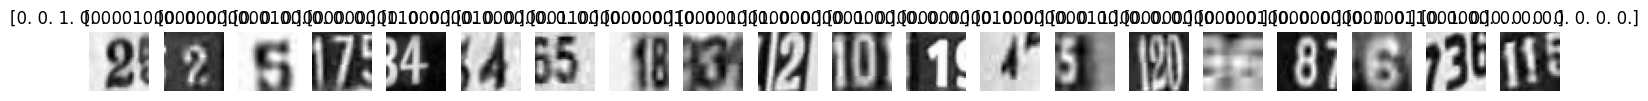

In [ ]:
plt.figure(figsize=(15, 4))

for i, idx in enumerate(random_indices):
    image = train_images_gray[idx, :, :, :]
    label = cat_train_labels[idx]

    plt.subplot(1, 20, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Stratified split (15% validation)
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images_gray,
    cat_train_labels,
    test_size=0.15,
    stratify=np.argmax(cat_train_labels, axis=1),
    random_state=42
)

In [ ]:
train_imgs.shape

(513729, 32, 32, 1)

In [ ]:
val_imgs.shape

(90659, 32, 32, 1)

In [ ]:
train_lbls.shape

(513729, 10)

In [ ]:
val_lbls.shape

(90659, 10)

# CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. Please use only what we learned in class.
* Compile and train the model (the recommended is a maximum of 30 epochs), making use of both training and validation sets during the training run.
* The model should track accuracy metric, and use early stopping during training.
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=10, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,786 (2.36 MB)

 Trainable params: 619,786 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stop
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train
model.fit(train_imgs,train_lbls,epochs=30,validation_data=(val_imgs,val_lbls),callbacks=[early_stop])

Epoch 1/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.8205 - loss: 0.5608 - val_accuracy: 0.9549 - val_loss: 0.1622
Epoch 2/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9484 - loss: 0.1826 - val_accuracy: 0.9640 - val_loss: 0.1366
Epoch 3/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.9575 - loss: 0.1535 - val_accuracy: 0.9629 - val_loss: 0.1375
Epoch 4/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9612 - loss: 0.1412 - val_accuracy: 0.9672 - val_loss: 0.1276
Epoch 5/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9640 - loss: 0.1326 - val_accuracy: 0.9688 - val_loss: 0.1213
Epoch 6/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9655 - loss: 0.1278 - val_accuracy: 0.9693 - val_loss: 0.1194
Epoch 7/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9667 - loss: 0.1240 - val_accuracy: 0.9693 - val_loss: 0.1225
Epoch 8/30
16055/16055 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 

In [ ]:
model.metrics_names # Check the metric names

['loss', 'compile_metrics']

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses

,accuracy,loss,val_accuracy,val_loss
0,0.902721,0.324831,0.954930,0.162200
1,0.950602,0.176437,0.963997,0.136565
2,0.957807,0.153704,0.962861,0.137525
3,0.960828,0.142849,0.967196,0.127583
4,0.963562,0.135306,0.968762,0.121255
5,0.965013,0.129435,0.969347,0.119449
6,0.966064,0.125630,0.969292,0.122537
7,0.967095,0.121628,0.971078,0.117439
8,0.967859,0.119363,0.968045,0.132404
9,0.968442,0.118479,0.968795,0.125223


<Axes: >

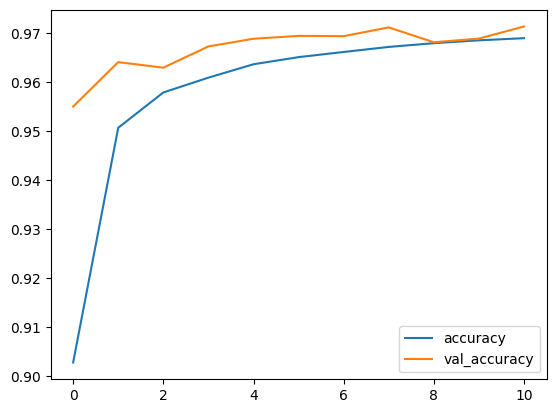

In [ ]:
losses[['accuracy','val_accuracy']].plot()

<Axes: >

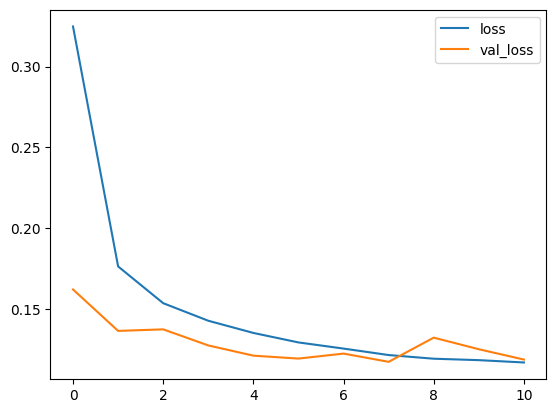

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
predictions = model.predict(test_images_gray)

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
predictions

array([[4.8619563e-11, 8.7852543e-09, 2.4123054e-07, ..., 1.6935695e-07,
        3.4333281e-09, 1.4450826e-08],
       [1.2798432e-09, 7.1566602e-09, 9.9999416e-01, ..., 2.2324438e-07,
        9.0855612e-10, 3.6524348e-09],
       [1.4622789e-08, 9.9998963e-01, 6.7177808e-07, ..., 9.8884368e-07,
        1.3059671e-08, 1.5191265e-08],
       ...,
       [6.8170480e-10, 1.3964177e-07, 4.4802335e-05, ..., 9.9995232e-01,
        3.3615491e-12, 3.8908124e-07],
       [1.2936059e-05, 7.7630782e-09, 1.3935372e-10, ..., 2.3640118e-10,
        1.5215099e-05, 1.1328984e-11],
       [1.9599569e-12, 1.4076382e-05, 4.7574801e-07, ..., 9.9998546e-01,
        5.5827988e-13, 1.5650263e-09]], dtype=float32)

In [ ]:
pred_binary = predictions > 0.5

In [ ]:
pred_binary

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False]])

In [ ]:
pred_class = np.argmax(predictions, axis=1)

In [ ]:
pred_class

array([5, 2, 1, ..., 7, 6, 7])

In [ ]:
cat_test_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
print(classification_report(test_labels,pred_class))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1744
           1       0.95      0.97      0.96      5099
           2       0.97      0.95      0.96      4149
           3       0.92      0.94      0.93      2882
           4       0.97      0.95      0.96      2523
           5       0.95      0.94      0.94      2384
           6       0.93      0.94      0.94      1977
           7       0.96      0.94      0.95      2019
           8       0.94      0.91      0.93      1660
           9       0.93      0.93      0.93      1595

    accuracy                           0.95     26032
   macro avg       0.94      0.94      0.94     26032
weighted avg       0.95      0.95      0.95     26032



In [ ]:
confusion_matrix(test_labels,pred_class)

array([[1669,   13,    6,    7,    2,    4,   16,    5,    5,   17],
       [  45, 4930,   22,   14,   21,   10,   12,   29,   10,    6],
       [   8,   37, 3961,   64,   14,   17,    5,   21,   10,   12],
       [   7,   40,   17, 2721,    4,   35,   13,    4,   19,   22],
       [  15,   59,    8,   16, 2386,    5,   14,    8,    3,    9],
       [   5,   10,   12,   59,    4, 2246,   26,    2,   11,    9],
       [  28,   17,    3,   12,    5,   24, 1855,    3,   24,    6],
       [   3,   69,   18,   11,    5,    9,    5, 1890,    1,    8],
       [  17,    7,    6,   28,    8,   11,   41,    2, 1513,   27],
       [  27,   12,   22,   14,    8,   10,    1,    2,    8, 1491]])

<Axes: >

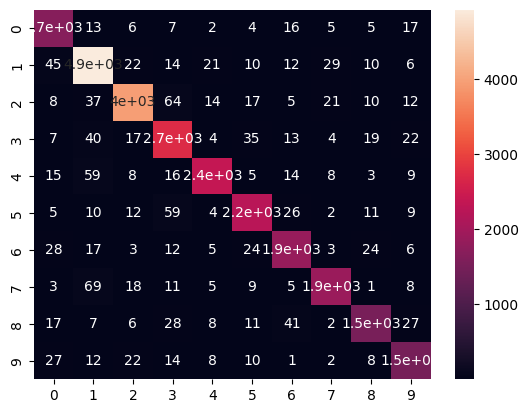

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_labels,pred_class),annot=True)

In [ ]:
my_number = test_images_gray[664]

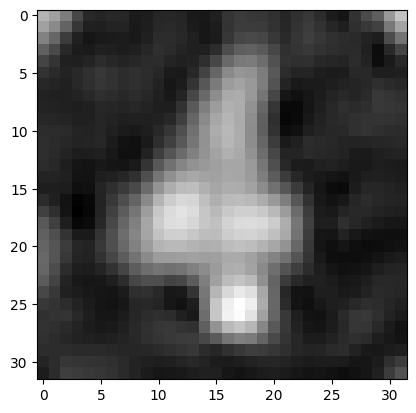

In [ ]:
plt.imshow(my_number.reshape(32, 32), cmap='gray')

In [ ]:
model.predict(my_number.reshape(1, 32, 32, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


array([[6.4053495e-07, 2.6309046e-05, 3.0764255e-05, 2.8490178e-06,
        9.9993253e-01, 6.6887559e-08, 1.5111578e-06, 4.9039277e-06,
        5.2862475e-08, 3.4097283e-07]], dtype=float32)

In [ ]:
np.round(model.predict(my_number.reshape(1, 32, 32, 1)), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
model.save('base_model_full_dataset.keras')

# Improvement
* Try to use ImageDataGenerator to augment the data.
* Try to add BatchNomalization layers using Keras API.
* Try to use a pre-trained CNN model for transfer learning.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#help(ImageDataGenerator)

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=8,
    fill_mode='nearest'
)

pass_gen = ImageDataGenerator()

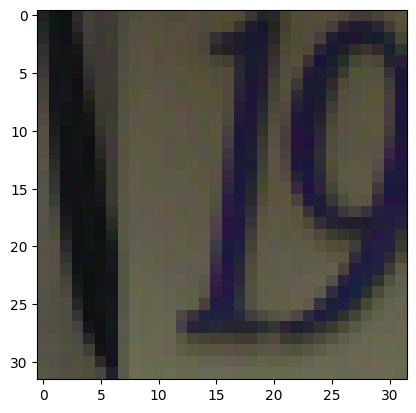

In [ ]:
plt.imshow(train_images[0])

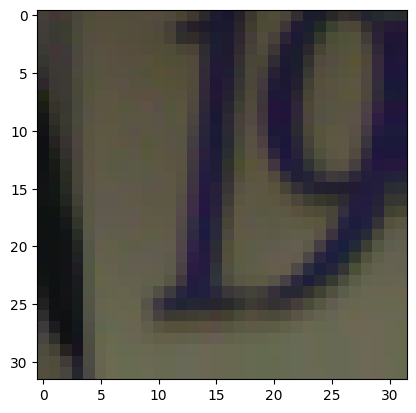

In [ ]:
plt.imshow(train_gen.random_transform(train_images[0]))

In [ ]:
BATCH = 64

In [ ]:
train_gen = train_gen.flow(
    train_imgs, # numpy array (N,32,32,1)
    train_lbls, # numpy array (N,10)
    batch_size=BATCH,
    shuffle=True
)

val_gen = pass_gen.flow(
    val_imgs,
    val_lbls,
    batch_size=BATCH,
    shuffle=False
)

test_gen = pass_gen.flow(
    test_images_gray,
    cat_test_labels,
    batch_size=BATCH,
    shuffle=False
)

In [ ]:
print("Samples :", train_gen.n)
print("Batch sz:", train_gen.batch_size)

batch_x, batch_y = train_gen[0]
print("Batch X shape:", batch_x.shape)
print("Batch Y shape:", batch_y.shape)

Samples : 513729
Batch sz: 64
Batch X shape: (64, 32, 32, 1)
Batch Y shape: (64, 10)


In [ ]:
model2 = Sequential()

# Convolutional Block 1
model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 1)))
model2.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Block 2
model2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Block 3
model2.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

# Fully Connected Layers
model2.add(Flatten())
model2.add(Dense(units=256, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(units=10, activation='softmax'))

# Compile
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train
model2.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8028/8028 ━━━━━━━━━━━━━━━━━━━━ 154s 19ms/step - accuracy: 0.7230 - loss: 0.8355 - val_accuracy: 0.9559 - val_loss: 0.1594
Epoch 2/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 150s 19ms/step - accuracy: 0.9193 - loss: 0.2731 - val_accuracy: 0.9666 - val_loss: 0.1258
Epoch 3/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 151s 19ms/step - accuracy: 0.9344 - loss: 0.2275 - val_accuracy: 0.9675 - val_loss: 0.1251
Epoch 4/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 152s 19ms/step - accuracy: 0.9415 - loss: 0.2026 - val_accuracy: 0.9671 - val_loss: 0.1223
Epoch 5/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 155s 19ms/step - accuracy: 0.9470 - loss: 0.1869 - val_accuracy: 0.9693 - val_loss: 0.1182
Epoch 6/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 153s 19ms/step - accuracy: 0.9492 - loss: 0.1784 - val_accuracy: 0.9717 - val_loss: 0.1104
Epoch 7/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 153s 19ms/step - accuracy: 0.9506 - loss: 0.1758 - val_accuracy: 0.9726 - val_loss: 0.1092
Epoch 8/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 159s 20ms/step - accuracy: 0.9532 - lo

In [ ]:
model2.metrics_names # Check the metric names

['loss', 'compile_metrics']

In [ ]:
losses2 = pd.DataFrame(model2.history.history)

In [ ]:
losses2

,accuracy,loss,val_accuracy,val_loss
0,0.842296,0.502098,0.955912,0.159390
1,0.923759,0.260971,0.966578,0.125800
2,0.936525,0.219445,0.967494,0.125083
3,0.942843,0.200806,0.967108,0.122278
4,0.946651,0.188646,0.969303,0.118165
5,0.949501,0.179973,0.971729,0.110425
6,0.950959,0.173497,0.972579,0.109186
7,0.953220,0.167676,0.972623,0.106470
8,0.953822,0.163964,0.972678,0.107391
9,0.955315,0.160435,0.973660,0.104333


<Axes: >

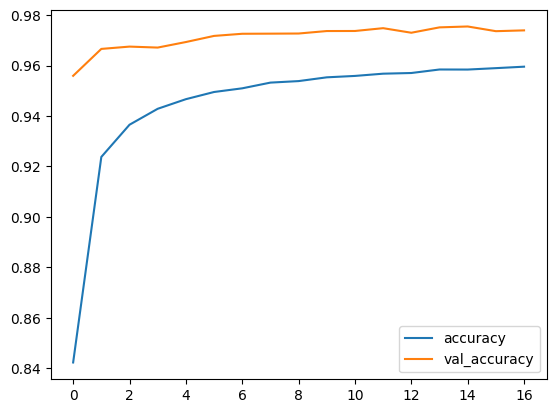

In [ ]:
losses2[['accuracy','val_accuracy']].plot()

<Axes: >

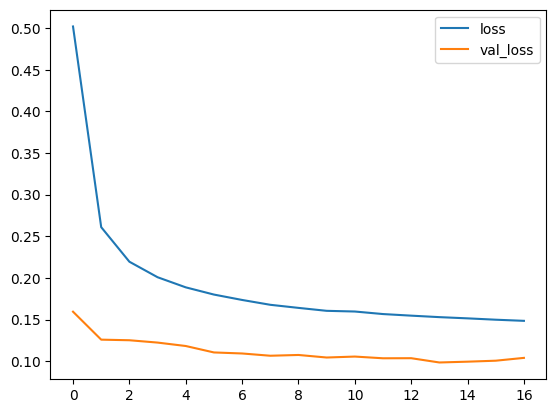

In [ ]:
losses2[['loss','val_loss']].plot()

In [ ]:
predictions2 = model2.predict(test_images_gray)

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
predictions2

array([[5.2060019e-09, 4.3295935e-07, 1.9128575e-07, ..., 5.7688095e-07,
        2.2260602e-09, 2.5183297e-07],
       [9.9598385e-11, 4.6322217e-08, 9.9999964e-01, ..., 1.1171285e-07,
        1.4305229e-10, 2.2930874e-10],
       [2.7705939e-06, 9.9817336e-01, 1.3308752e-06, ..., 1.1998583e-05,
        2.5519222e-07, 4.2033093e-07],
       ...,
       [6.9868920e-09, 2.2034372e-05, 7.8806333e-06, ..., 9.9996006e-01,
        1.6232604e-10, 1.9304376e-07],
       [5.6024688e-05, 4.0376702e-07, 2.0019315e-09, ..., 5.9883138e-09,
        1.3196832e-06, 3.2170625e-08],
       [6.8687855e-10, 3.7536487e-05, 7.8305834e-07, ..., 9.9996173e-01,
        1.6771548e-12, 6.2388050e-09]], dtype=float32)

In [ ]:
pred2_binary = predictions2 > 0.5

In [ ]:
pred2_binary

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False]])

In [ ]:
pred2_class = np.argmax(predictions2, axis=1)

In [ ]:
pred2_class

array([5, 2, 1, ..., 7, 6, 7])

In [ ]:
print(classification_report(test_labels,pred2_class))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1744
           1       0.97      0.96      0.97      5099
           2       0.97      0.98      0.97      4149
           3       0.94      0.95      0.94      2882
           4       0.96      0.97      0.97      2523
           5       0.96      0.95      0.95      2384
           6       0.95      0.95      0.95      1977
           7       0.96      0.95      0.96      2019
           8       0.95      0.92      0.94      1660
           9       0.95      0.92      0.94      1595

    accuracy                           0.96     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.96      0.96      0.96     26032



In [ ]:
confusion_matrix(test_labels,pred2_class)

array([[1679,   10,    7,    8,    1,    7,   21,    4,    0,    7],
       [  22, 4915,   25,   27,   38,   11,   11,   37,    7,    6],
       [   5,   16, 4056,   16,   10,    8,    5,   24,    4,    5],
       [   5,   20,   24, 2729,    6,   33,   10,    6,   21,   28],
       [   6,   28,   16,    5, 2447,    3,    3,    4,    3,    8],
       [   5,   14,    6,   54,    5, 2268,   19,    1,    9,    3],
       [  21,   13,    4,    9,    5,   23, 1875,    3,   23,    1],
       [   2,   55,   20,   11,    6,    2,    0, 1919,    1,    3],
       [  15,    5,   13,   25,   11,    6,   36,    0, 1529,   20],
       [  38,   10,   23,   17,    9,    9,    3,    1,   11, 1474]])

<Axes: >

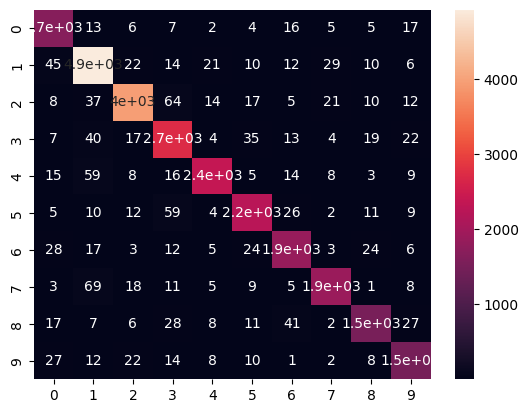

In [ ]:
sns.heatmap(confusion_matrix(test_labels,pred_class),annot=True)

In [ ]:
my_number = test_images_gray[1000]

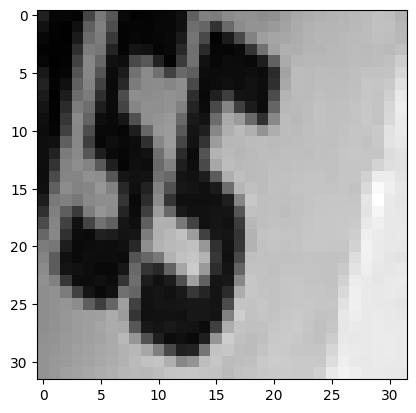

In [ ]:
plt.imshow(my_number.reshape(32, 32), cmap='gray')

In [ ]:
model2.predict(my_number.reshape(1, 32, 32, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


array([[4.51854554e-10, 2.19837915e-07, 8.16593959e-10, 9.18656099e-07,
        1.22803447e-08, 9.99963164e-01, 3.54813783e-05, 7.46057272e-10,
        8.70424888e-09, 1.09917956e-07]], dtype=float32)

In [ ]:
np.round(model2.predict(my_number.reshape(1, 32, 32, 1)), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
model2.save('data_augmentation_model_full_dataset.keras')

Adding Batching Normalization

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Activation

model3 = Sequential()

# Convolutional Block 1
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', use_bias=False, input_shape=(32, 32, 1)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Block 2
model3.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPool2D((2, 2)))

# Convolutional Block 3
model3.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPool2D((2, 2)))

# Fully Connected Layers
model3.add(Flatten())
model3.add(Dense(units=256, activation='relu'))
model3.add(Dropout(rate=0.5))
model3.add(Dense(units=10, activation='softmax'))

# Compile
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train
model3.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 162s 20ms/step - accuracy: 0.4983 - loss: 1.3425 - val_accuracy: 0.9453 - val_loss: 0.2114
Epoch 2/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 154s 19ms/step - accuracy: 0.8592 - loss: 0.4366 - val_accuracy: 0.9572 - val_loss: 0.1576
Epoch 3/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 162s 20ms/step - accuracy: 0.9382 - loss: 0.2218 - val_accuracy: 0.9713 - val_loss: 0.1136
Epoch 4/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 154s 19ms/step - accuracy: 0.9516 - loss: 0.1760 - val_accuracy: 0.9691 - val_loss: 0.1176
Epoch 5/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 153s 19ms/step - accuracy: 0.9569 - loss: 0.1581 - val_accuracy: 0.9733 - val_loss: 0.1059
Epoch 6/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 152s 19ms/step - accuracy: 0.9604 - loss: 0.1464 - val_accuracy: 0.9722 - val_loss: 0.1056
Epoch 7/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 153s 19ms/step - accuracy: 0.9618 - loss: 0.1398 - val_accuracy: 0.9744 - val_loss: 0.1000
Epoch 8/30
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 155s 19ms/step - accuracy: 

In [ ]:
model3.metrics_names # Check the metric names

['loss', 'compile_metrics']

In [ ]:
losses3 = pd.DataFrame(model3.history.history)

In [ ]:
losses3

,accuracy,loss,val_accuracy,val_loss
0,0.625666,1.002552,0.945334,0.211423
1,0.891234,0.353513,0.957158,0.157647
2,0.942843,0.207207,0.971332,0.113594
3,0.952714,0.172306,0.969126,0.117628
4,0.957357,0.156275,0.973284,0.105890
5,0.960697,0.144803,0.972181,0.105557
6,0.962375,0.138645,0.974365,0.100029
7,0.964549,0.132129,0.973141,0.103281
8,0.965544,0.128588,0.963798,0.132867
9,0.966360,0.125442,0.974123,0.098695


<Axes: >

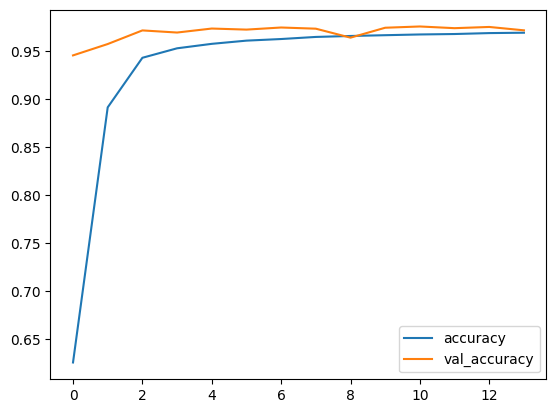

In [ ]:
losses3[['accuracy','val_accuracy']].plot()

<Axes: >

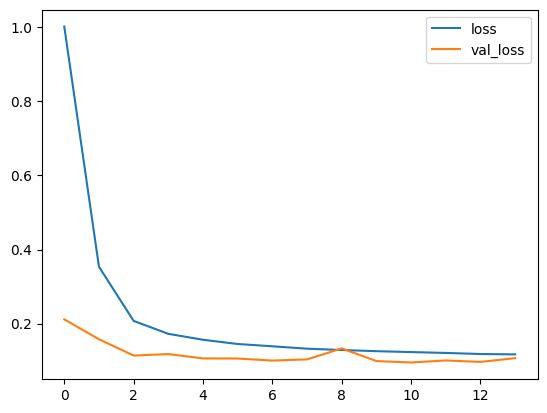

In [ ]:
losses3[['loss','val_loss']].plot()

In [ ]:
predictions3 = model3.predict(test_images_gray)

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
predictions3

array([[2.8453124e-07, 2.8197126e-05, 8.7615354e-06, ..., 1.5913520e-05,
        5.3405046e-07, 4.4351059e-06],
       [8.0707914e-06, 6.1902298e-05, 9.9964201e-01, ..., 4.7926307e-05,
        2.4544610e-05, 3.5739791e-05],
       [6.1016585e-06, 9.9915576e-01, 2.3376668e-05, ..., 6.3453408e-05,
        1.7735758e-05, 1.9348902e-06],
       ...,
       [5.8625133e-08, 8.8640722e-05, 1.0469111e-04, ..., 9.9977797e-01,
        3.2194031e-08, 1.8442601e-05],
       [1.5912355e-03, 4.6303289e-04, 4.1217943e-05, ..., 5.1023730e-05,
        1.8465503e-04, 3.5647965e-05],
       [7.2829508e-08, 1.1128939e-03, 1.3698303e-05, ..., 9.9885786e-01,
        2.6150971e-08, 8.8013776e-06]], dtype=float32)

In [ ]:
pred3_binary = predictions3 > 0.5

In [ ]:
pred3_binary

array([[False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False]])

In [ ]:
pred3_class = np.argmax(predictions3, axis=1)

In [ ]:
pred3_class

array([5, 2, 1, ..., 7, 6, 7])

In [ ]:
print(classification_report(test_labels,pred3_class))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1744
           1       0.95      0.97      0.96      5099
           2       0.97      0.96      0.97      4149
           3       0.93      0.94      0.94      2882
           4       0.96      0.96      0.96      2523
           5       0.95      0.95      0.95      2384
           6       0.94      0.94      0.94      1977
           7       0.95      0.93      0.94      2019
           8       0.96      0.91      0.94      1660
           9       0.94      0.95      0.94      1595

    accuracy                           0.95     26032
   macro avg       0.95      0.95      0.95     26032
weighted avg       0.95      0.95      0.95     26032



In [ ]:
confusion_matrix(test_labels,pred3_class)

array([[1645,   16,   11,   13,    3,    7,   30,    2,    0,   17],
       [  18, 4938,   17,   36,   41,   10,    6,   27,    3,    3],
       [   4,   39, 3999,   22,   17,    4,    3,   47,    5,    9],
       [   7,   27,   19, 2718,   10,   39,    8,    8,   17,   29],
       [   6,   44,   12,   11, 2429,    4,    5,    7,    2,    3],
       [   3,    8,    7,   59,    7, 2265,   19,    3,    5,    8],
       [  17,   12,    9,    9,    9,   25, 1866,    2,   24,    4],
       [   4,   99,   14,    4,    3,    3,    1, 1885,    1,    5],
       [  10,   12,   11,   24,    9,    9,   39,    4, 1518,   24],
       [  14,   10,   20,   13,    7,   10,    1,    1,    6, 1513]])

<Axes: >

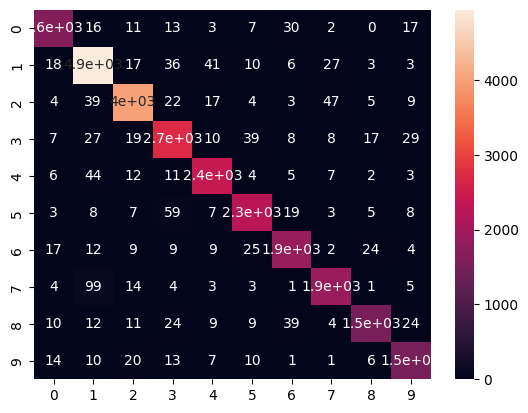

In [ ]:
sns.heatmap(confusion_matrix(test_labels,pred3_class),annot=True)

In [ ]:
my_number = test_images_gray[3333]

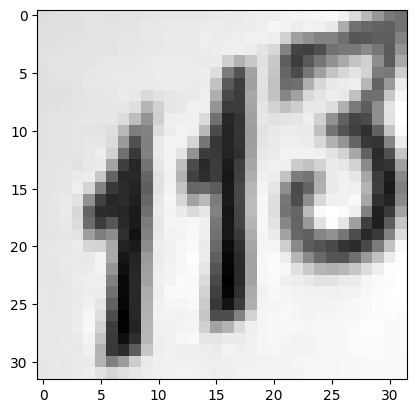

In [ ]:
plt.imshow(my_number.reshape(32, 32), cmap='gray')

In [ ]:
test_labels[3333]

np.uint8(1)

In [ ]:
model3.predict(my_number.reshape(1, 32, 32, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


array([[4.4823580e-09, 9.9999940e-01, 1.3545171e-08, 2.2188436e-09,
        4.0327555e-09, 9.5269472e-09, 2.9174885e-09, 5.8109066e-07,
        2.6005411e-09, 1.9191178e-09]], dtype=float32)

In [ ]:
np.round(model3.predict(my_number.reshape(1, 32, 32, 1)), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
model3.save('batch_normalization_model_full_dataset.keras')